<a href="https://colab.research.google.com/github/Byeon-MJ/ML_Mini_Project_CreditCard/blob/main/CreditCard_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Module Import

In [2]:
# !pip install catboost

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Dataset Load

In [4]:
# train = pd.read_csv('/content/gdrive/MyDrive/Project/ML_Mini_CreditCard/dataset/train.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/Project/ML_Mini_CreditCard/dataset/test.csv')
# submission = pd.read_csv('/content/gdrive/MyDrive/Project/ML_Mini_CreditCard/dataset/sample_submission.csv')

train = pd.read_csv('https://raw.githubusercontent.com/Byeon-MJ/ML_Mini_Project_CreditCard/main/dataset/train.csv')

In [5]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


# Data pre-Processing
**종속 변수**
* credit : 
        사용자의 신용카드 대금 연체를 기준으로 한 신용도
        
        => 낮을수록 높은 신용의 신용카드 사용자를 의미함

**독립 변수**
* gender
* car : 차량 소유 여부 
* reality : 부동산 소유 여부
* child_num : 자녀 수
* income_total : 연간 소득
* income_type : 소득 분류
        ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
* edu_type : 교육 수준
         ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
* family_type : 결혼 여부
        ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
* house_type : 생활 방식
        ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']
* DAYS_BIRTH : 출생일
        데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
* DAYS_EMPLOYED : 업무 시작일, 
        데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
    
        양수 값은 고용되지 않은 상태를 의미함
* FLAG_MOBIL : 핸드폰 소유 여부
* work_phone : 업무용 전화 소유 여부
* phone : 전화 소유 여부
* email : 이메일 소유 여부
* occyp_type : 직업 유형
* family_size : 가족 규모
* begin_month : 신용카드 발급 월
        데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


In [6]:

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [14]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [15]:
train.describe(include='O')

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
count,26457,26457,26457,26457,26457,26457,26457,18286
unique,2,2,2,5,5,5,6,18
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,17697,16410,17830,13645,17995,18196,23653,4512


## Missing Value Check

In [7]:
import missingno as msno

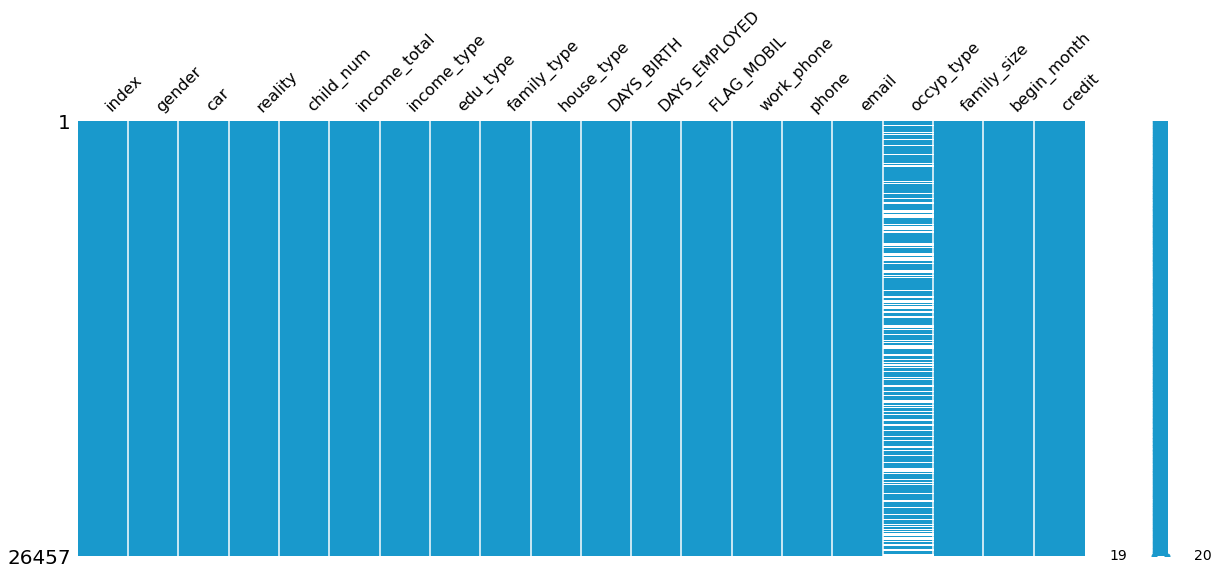

In [11]:
msno.matrix(df = train, color=(0.1, 0.6, 0.8), figsize=(20, 8))
plt.show()

* occyp_type -> null 값 처리
* 직업유형 'unknown' 으로 바꿔주기

In [12]:
train.isna().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [13]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

## Outlier Check

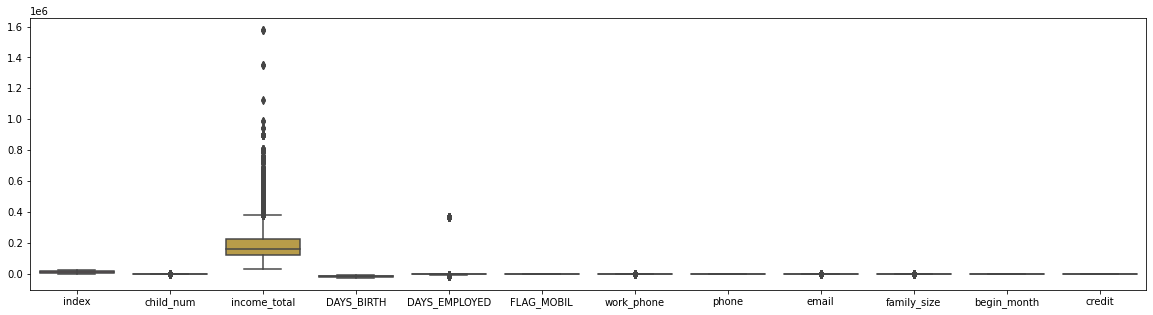

In [20]:
plt.figure(figsize=(20,5))
sns.boxplot(data=train)
plt.show()

In [28]:
train.describe().columns

Index(['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit'],
      dtype='object')

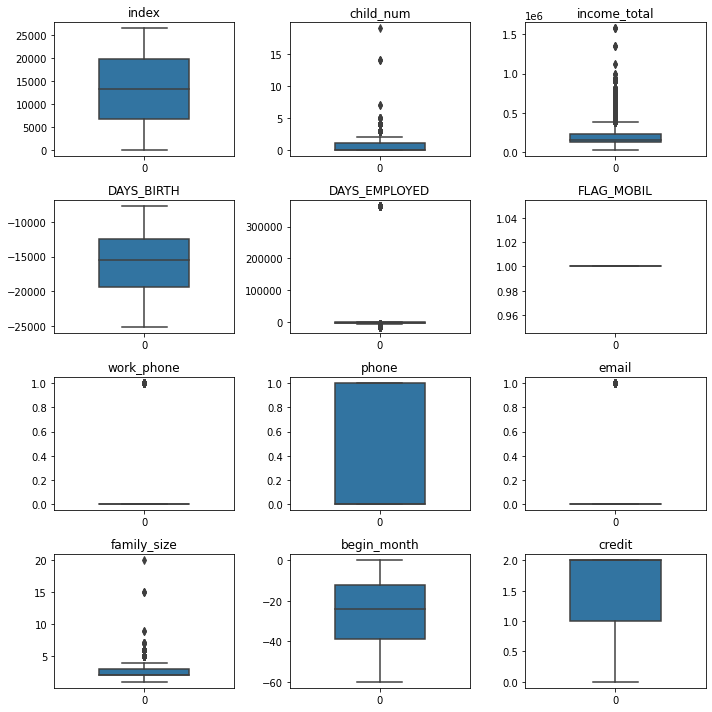

In [42]:
fig = plt.figure(figsize=(10, 10))

for i, content in enumerate(train.describe().columns):
    plt.subplot(4, 3, i+1)
    plt.title(content)
    sns.boxplot(data=train[content], width=0.5)
    
fig.tight_layout()
plt.show()

### child_num

In [44]:
train['child_num'].unique()

array([ 0,  1,  2,  3,  4,  5, 14, 19,  7])

In [59]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

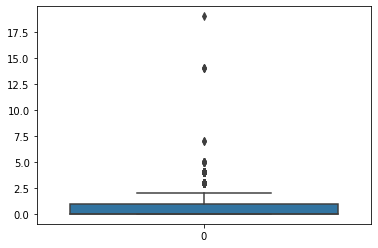

In [54]:
sns.boxplot(data=train['child_num'])

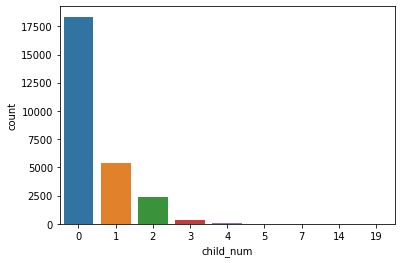

In [51]:
sns.countplot(data=train, x='child_num')

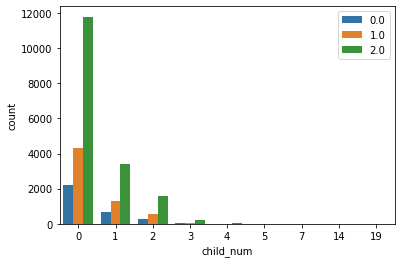

In [53]:
sns.countplot(data=train, x='child_num', hue='credit')
plt.legend(loc='upper right')
plt.show()

### family_size

In [60]:
train['family_size'].unique()

array([ 2.,  3.,  4.,  1.,  5.,  6.,  7., 15., 20.,  9.])

In [63]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

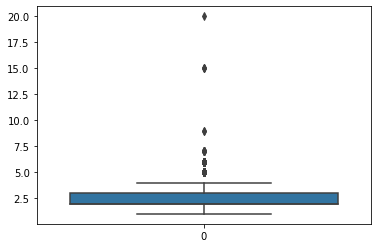

In [55]:
sns.boxplot(data=train['family_size'])

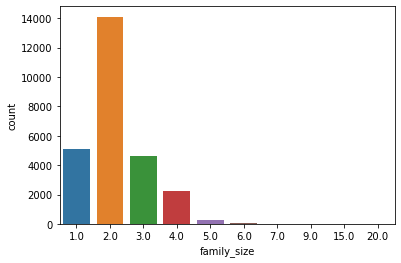

In [56]:
sns.countplot(data=train, x='family_size')

## Data pre-Processing Strategy
* occyp_type : null값 처리 -> 'unknown'? drop?
* outlier : child_num, family_size
* Labeling : gender, car, income_type, edu_type, family_type, house_type, 
* child_num : outlier 판단할 것(3, 4, 5, 7?) / 처리(14, 19)

### flag_mobil
전부 1로 같아서 버려도 되는 컬럼

In [57]:
train['FLAG_MOBIL'].unique()

array([1])

### type Col
-> Label Encoding

In [66]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [65]:
train.columns[6:10]

Index(['income_type', 'edu_type', 'family_type', 'house_type'], dtype='object')

In [81]:
type_col = train.columns[6:10]
for i in type_col:
    print(f'{i} :', train[i].unique())
    # print(train[i].value_counts())

income_type : ['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
edu_type : ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
family_type : ['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
house_type : ['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


### Binary variables
: gender, car, reality

In [74]:
bin_col = train.columns[1:4]
bin_col

Index(['gender', 'car', 'reality'], dtype='object')

In [78]:
for i in bin_col:
    print(f'{i} :', train[i].unique())
    print(train[i].value_counts())

gender : ['F' 'M']
F    17697
M     8760
Name: gender, dtype: int64
car : ['N' 'Y']
N    16410
Y    10047
Name: car, dtype: int64
reality : ['N' 'Y']
Y    17830
N     8627
Name: reality, dtype: int64


: FLAG_MOBIL, work_phoen, phone, email

In [76]:
bin2_col = train.columns[12: 16]
bin2_col

Index(['FLAG_MOBIL', 'work_phone', 'phone', 'email'], dtype='object')

In [79]:
for i in bin2_col:
    print(f'{i} :', train[i].unique())
    print(train[i].value_counts())

FLAG_MOBIL : [1]
1    26457
Name: FLAG_MOBIL, dtype: int64
work_phone : [0 1]
0    20511
1     5946
Name: work_phone, dtype: int64
phone : [0 1]
0    18672
1     7785
Name: phone, dtype: int64
email : [0 1]
0    24042
1     2415
Name: email, dtype: int64
